In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

<AxesSubplot:>

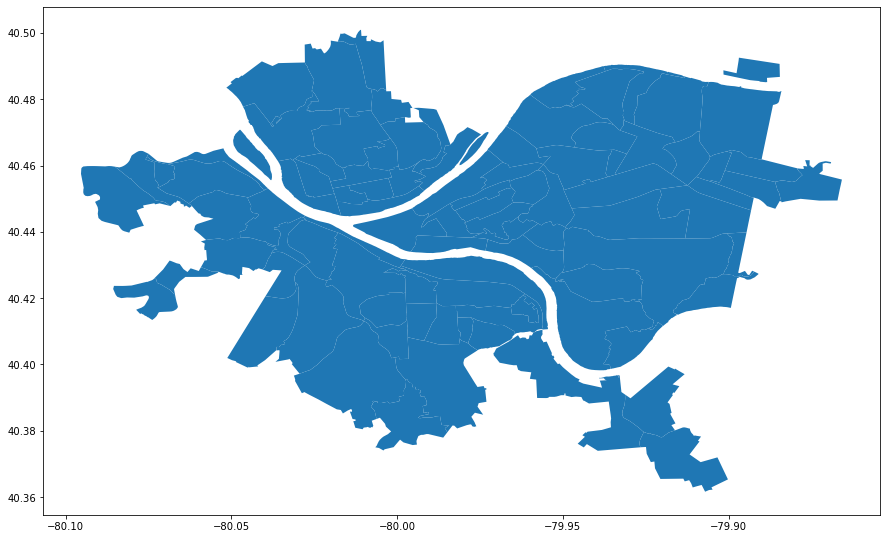

In [2]:
street_map = gpd.read_file('kx-pittsburgh-pa-neighborhoods-SHP/pittsburgh-pa-neighborhoods.shp')
# street_map = gpd.read_file('AlleghenyCounty_StreetCenterlines202204/AlleghenyCounty_StreetCenterlines202204.shp')

fig, ax = plt.subplots(figsize = (15,15))
street_map.plot(ax=ax)

In [10]:
API_KEY = "wfRd7z0B6aEUV9N_WM_RyQ7XxZBZAdIs0xwj3NZDA55MlS2uFhoeaR9CC2033NSG9S_O6dcPTotNWjvxS-abB7U_cAibgWJEQFSqMAinJOtO56sqt2QBae3aqsoAYnYx"

In [4]:
def yelp_search(query):
    """
    Make an authenticated request to the Yelp API.

    Args:
        query (string): Search term

    Returns:
        total (integer): total number of businesses on Yelp corresponding to the query
        businesses (list): list of dicts representing each business
    """

    payload = {'location': query}
    headers = {'Authorization': 'Bearer '+ API_KEY}
    response = requests.get("https://api.yelp.com/v3/businesses/search", headers=headers, params=payload)
    response.raise_for_status()
    json = response.json()

    return json['total'], json['businesses']

In [5]:
def all_restaurants(query):
    """
    Retrieve ALL the restaurants on Yelp for a given query.

    Args:
        query (string): Search term

    Returns:
        results (list): list of dicts representing each business
    """

    payload = {'location': query, 'categories': 'restaurants', 'limit': 50}
    headers = {'Authorization': 'Bearer '+ API_KEY}
    offset = 0
    res = []
    
    # call endpoint until no additional data is received
    while(offset < 1000):
        payload['offset'] = offset
        try:
            response = requests.get("https://api.yelp.com/v3/businesses/search", headers=headers, params=payload)
            response.raise_for_status()
        except requests.exceptions.HTTPError:
            break
        
        json = response.json()

        if len(json['businesses']) < 1:
            break

        offset += len(json['businesses'])
        res.extend(json['businesses'])
        time.sleep(0.5)
    return pd.json_normalize(res)

In [44]:
from tqdm import tqdm
import requests
import time

master_df = pd.DataFrame()
pittsburgh_zipcodes = [15106, 15120, 15201, 15203, 15204, 15205, 15206, 15207, 15208, 15210, 15211, 15212, 15213, 15214, 15215, 15216, 15217, 15218, 15219, 15220, 15221, 15222, 15224, 15226, 15227, 15232, 15233, 15234, 15235, 15236, 15238, 15260, 15290]

# est. runtime 10 min
for zip in tqdm(pittsburgh_zipcodes):
  df = all_restaurants(zip)
  # strict checking of zip code, can comment out for more data
  df = df[df['location.zip_code'] == str(zip)]
  master_df = pd.concat([master_df, df])

master_df = master_df.drop_duplicates(subset=['id'])

100%|██████████| 33/33 [10:22<00:00, 18.87s/it]


In [45]:
import random
r = lambda: random.randint(0,255)
print('#%02X%02X%02X' % (r(),r(),r()))
colors = []

for i in range(len(pittsburgh_zipcodes)):
    while True:
        c = '#%02X%02X%02X' % (r(),r(),r())
        if c not in colors: break
    colors.append(c)

print(colors)

#E2BB68
['#C369AA', '#89CC0C', '#09EDAD', '#0A80D0', '#169568', '#4874C6', '#2D7A8E', '#935540', '#C53611', '#A26B13', '#1A75AF', '#0AB6A5', '#E439A5', '#98C5A9', '#CF1328', '#4F193F', '#820A62', '#4E4658', '#085963', '#9D5E29', '#3E04E9', '#F5D410', '#9FE56B', '#1504CE', '#46D471', '#014F9E', '#EA2297', '#152059', '#F4AC8D', '#95B4C5', '#06399A', '#304351', '#88354A']


/Users/emilyzhang/miniconda3/lib/python3.8/site-packages/geopandas/plotting.py:484: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


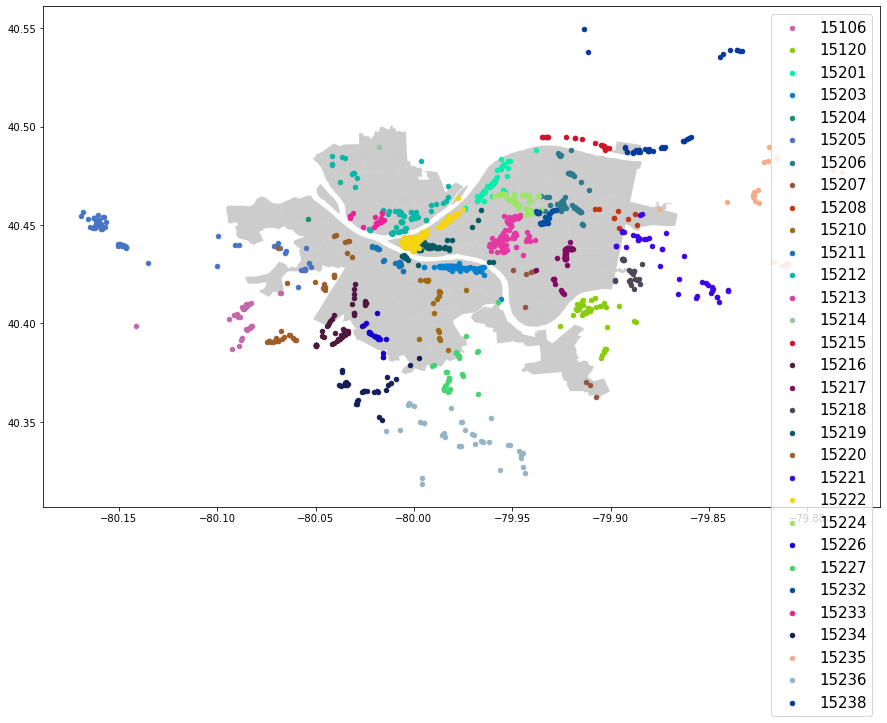

In [48]:
street_map = gpd.read_file('kx-pittsburgh-pa-neighborhoods-SHP/pittsburgh-pa-neighborhoods.shp')
# street_map = gpd.read_file('AlleghenyCounty_StreetCenterlines202204/AlleghenyCounty_StreetCenterlines202204.shp')

fig, ax = plt.subplots(figsize = (15,15))
street_map.plot(ax=ax, alpha=0.4, color='grey')
gdf = gpd.GeoDataFrame(master_df, geometry=gpd.points_from_xy(master_df["coordinates.longitude"], master_df["coordinates.latitude"]))
for i in range(len(pittsburgh_zipcodes)):
    zipcode = str(pittsburgh_zipcodes[i])
    color = colors[i]
    gdf[gdf['location.zip_code'] == zipcode].plot(ax=ax, markersize=20, color=color, label=zipcode)
plt.legend(prop={'size':15})